In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

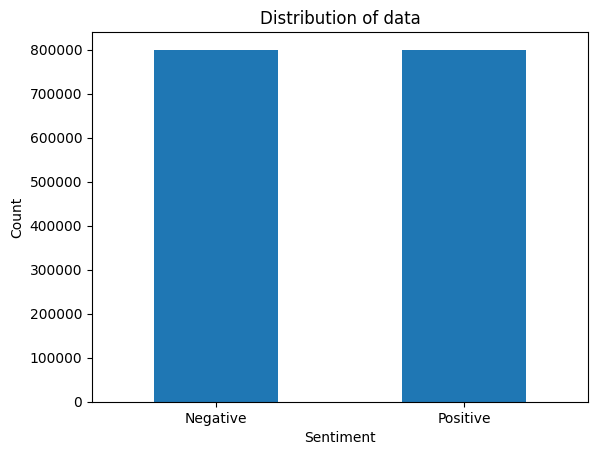

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                            encoding=DATASET_ENCODING, names=DATASET_COLUMNS, low_memory=False)

twitter_data['sentiment'] = pd.to_numeric(twitter_data['sentiment'], errors='coerce').fillna(0).astype('int64')
twitter_data = twitter_data.loc[:, ['sentiment', 'text']]

twitter_data['sentiment'] = twitter_data['sentiment'].replace(4, 1)

ax = twitter_data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.show()

text, sentiment = list(twitter_data['text']), list(twitter_data['sentiment'])


In [ ]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [ ]:
def preprocess(textdata):
    processedText = []

    wordLemm = WordNetLemmatizer()


    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()


        tweet = re.sub(urlPattern,' URL',tweet)
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        tweet = re.sub(userPattern,' USER', tweet)
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
result_df = pd.DataFrame({
    'processed_text': processedtext,
    'sentiment': sentiment
})

result_df.to_csv('/content/processed_twitter_data.csv', index=False)
print('Processed data saved to processed_twitter_data.csv.')

Processed data saved to processed_twitter_data.csv.


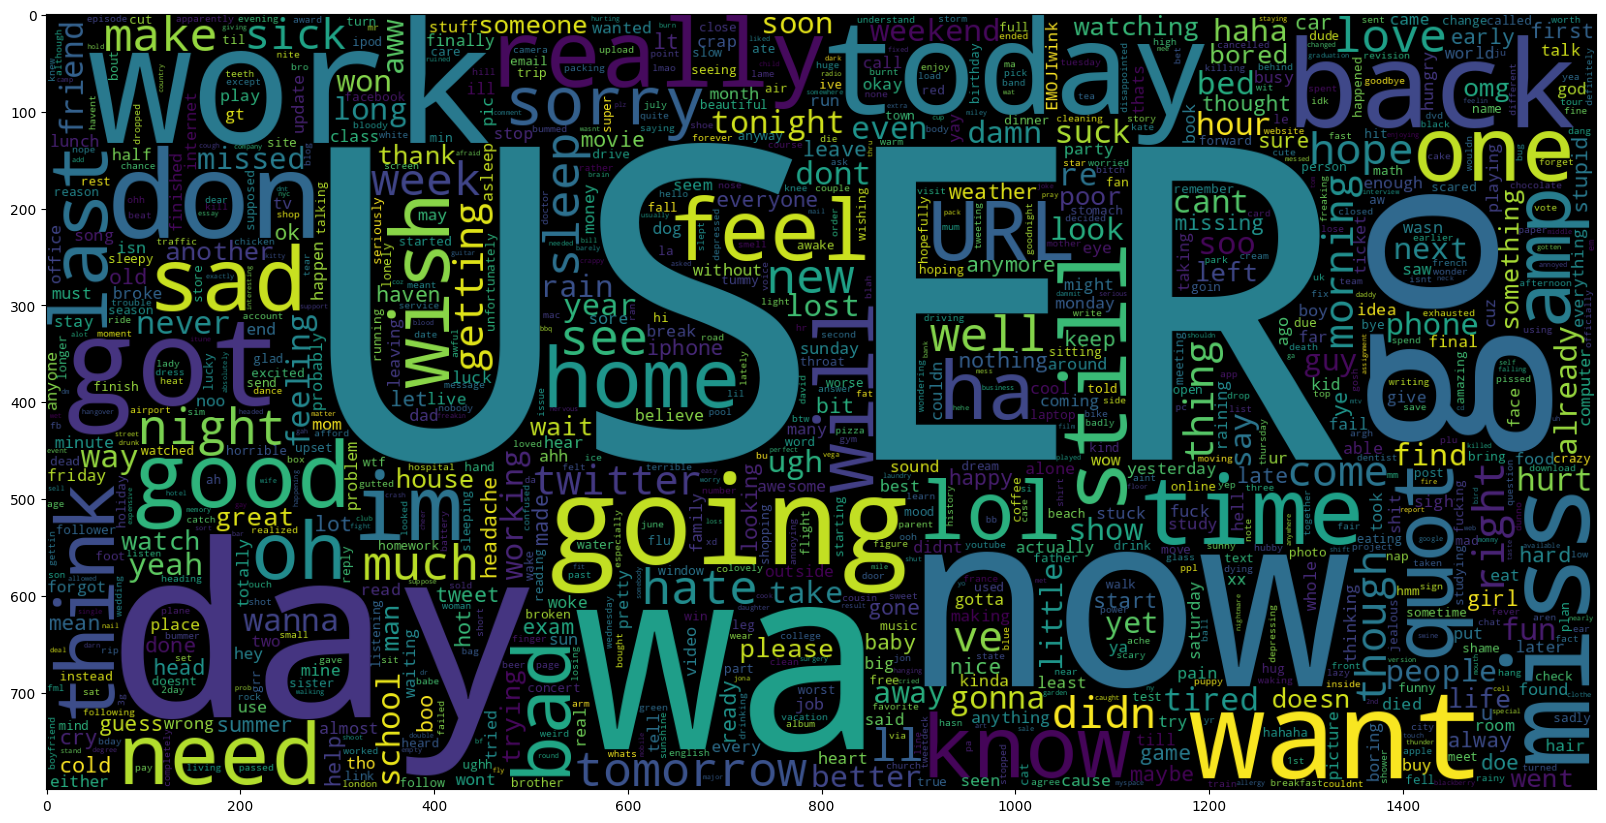

In [ ]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

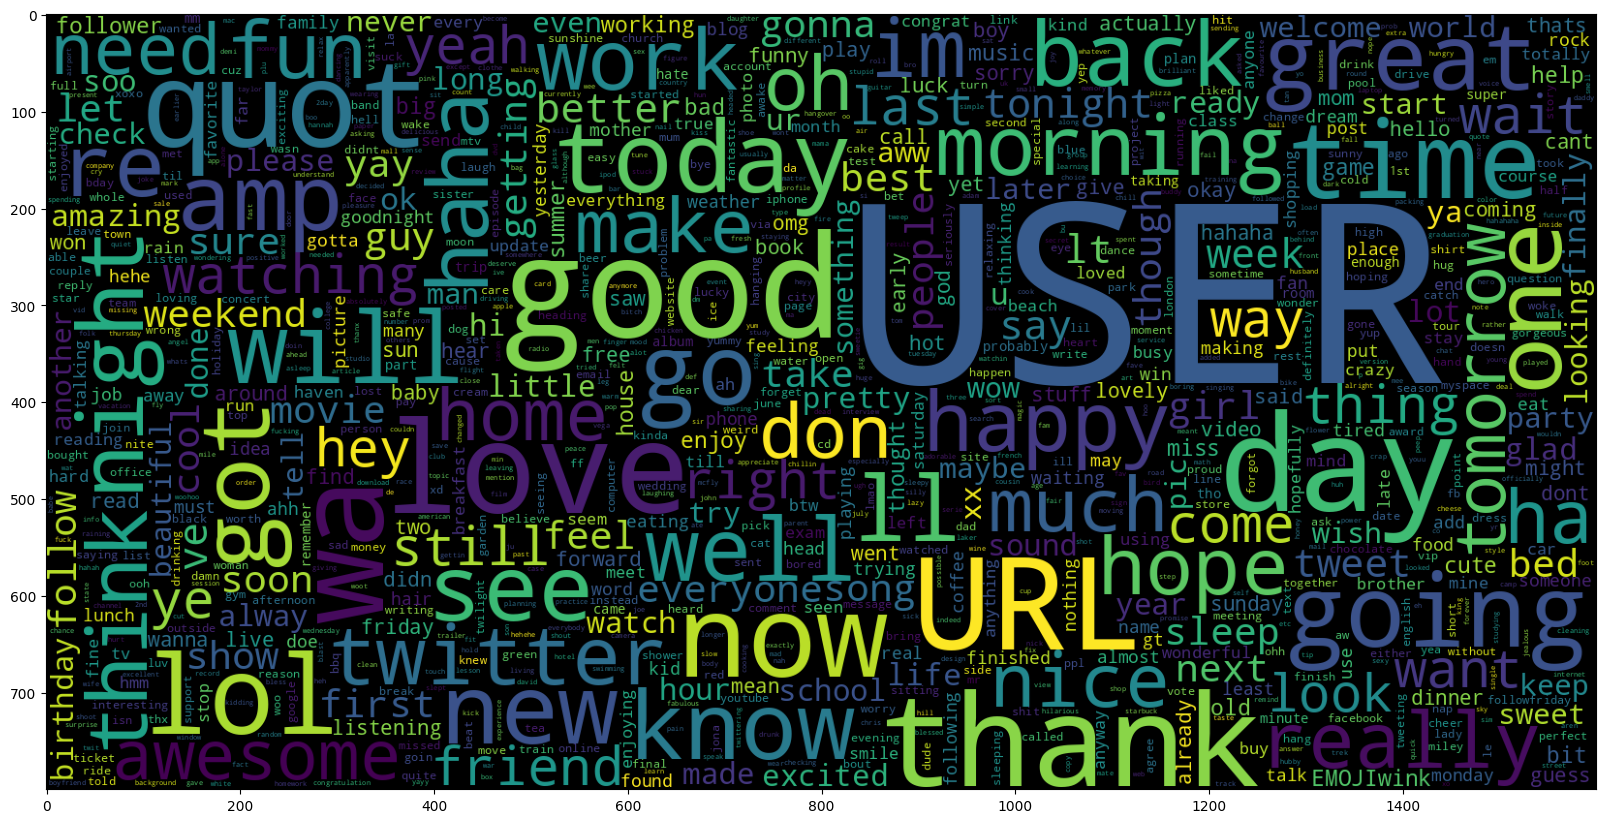

In [ ]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def model_Evaluate(model):

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))
    print(precision_score(y_test, y_pred))
    print(recall_score(y_test, y_pred))
    print(f1_score(y_test, y_pred))

    cf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000

0.8018625
0.796703836518151
0.810702056934343
0.8036419944255188


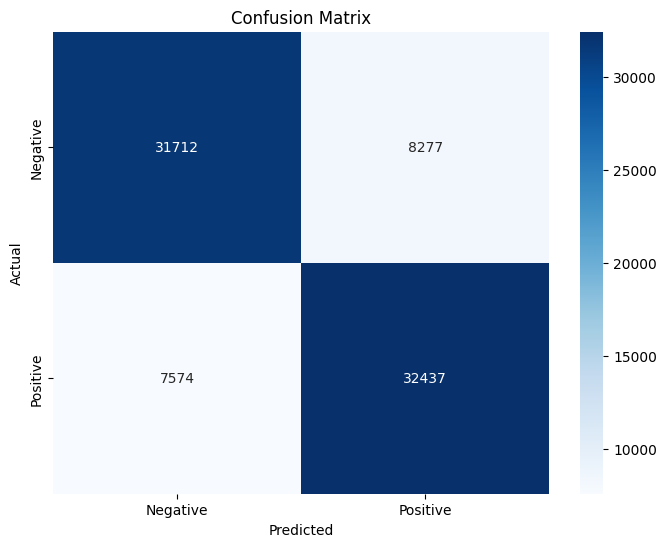

In [ ]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000

0.81845
0.8130388857500799
0.8272225138087026
0.8200693756194252


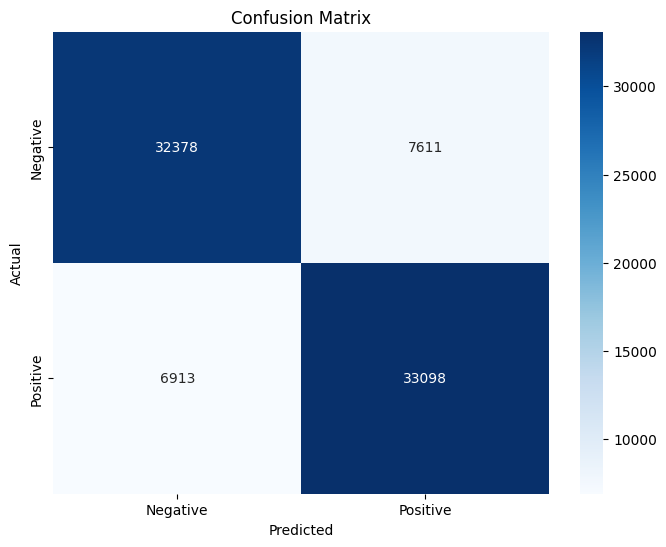

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000

0.8256875
0.819483257341766
0.8355202319362175
0.8274240455417363


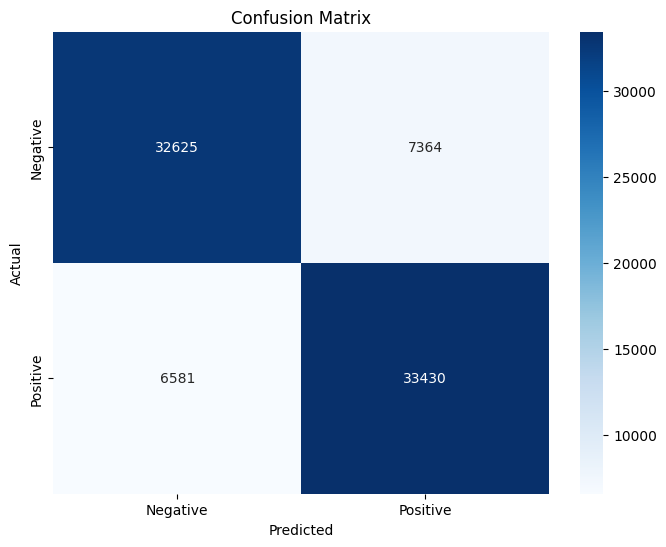

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [ ]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('Sentiment-SVC.pickle', 'wb')
pickle.dump(SVCmodel, file)
file.close()

              precision    recall  f1-score   support

           0       0.74      0.68      0.71     39989
           1       0.71      0.77      0.73     40011

    accuracy                           0.72     80000
   macro avg       0.73      0.72      0.72     80000
weighted avg       0.73      0.72      0.72     80000

0.7236875
0.7063473771549738
0.7659643598010547
0.7349488602980851


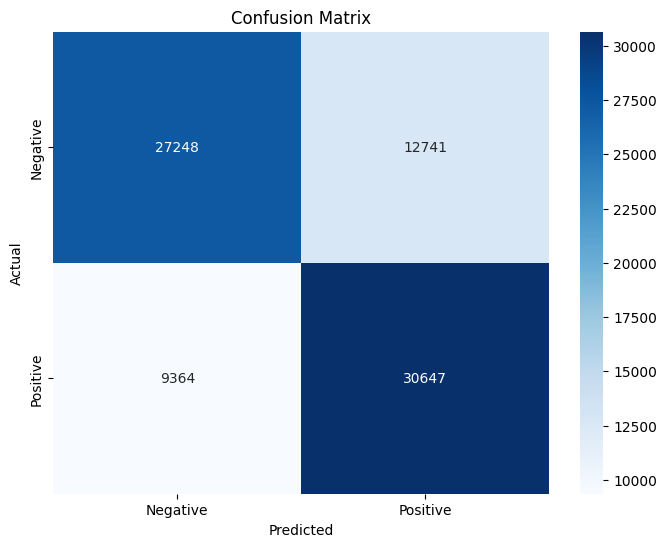

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)
model_Evaluate(rf_model)

In [ ]:
file = open('Sentiment-RF.pickle', 'wb')
pickle.dump(rf_model, file)
file.close()

In [ ]:
import pickle
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def load_models():

    with open('/content/vectoriser-ngram-(1,2).pickle', 'rb') as file:
        vectoriser = pickle.load(file)

    with open('/content/Sentiment-LR.pickle', 'rb') as file:
        LRmodel = pickle.load(file)

    print(vectoriser)
    return vectoriser, LRmodel

def preprocess(textdata):

    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

    processedText = []


    wordLemm = WordNetLemmatizer()

    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        tweet = re.sub(urlPattern,' URL',tweet)
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        tweet = re.sub(userPattern,' USER', tweet)
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

def predict(vectoriser, model, text):
    textdata = vectoriser.transform(preprocess([text]))
    sentiment = model.predict(textdata)

    df = pd.DataFrame([(text, sentiment[0])], columns=['text', 'sentiment'])
    df['sentiment'] = df['sentiment'].replace([0, 1], ["Negative", "Positive"])
    return df

if __name__ == "__main__":
    vectoriser, LRmodel = load_models()

    user_input = input("Enter a tweet: ")

    result_df = predict(vectoriser, LRmodel, user_input)

    print(result_df)